<div class='flex gap-1 items-center'>
    <img alt='self llama' src='../images/self-rag.jpeg' width='128' height='128' class='rounded'>
    <h1>Self Corrective RAG with LangGraph and Groq Llama 3</h1>
</div>

---


## Install dependencies

```bash
pip install langchain langchain-core langchain-community langchain-groq langgraph wikipedia
```


## Import libraries


In [1]:
from typing import Literal, TypedDict
from langchain_core.documents import Document
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_groq.chat_models import ChatGroq
from langchain_community.retrievers import WikipediaRetriever
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## Basic RAG Components


### Language Model


In [2]:
llm = ChatGroq(
    model='llama3-groq-8b-8192-tool-use-preview',
    temperature=0.45
)

llm_checker = ChatGroq(
    model='llama3-groq-8b-8192-tool-use-preview',
    temperature=0.0
)

res = llm.invoke('Hi! How are you today?')

res.content

"I'm doing well, thank you! How can I assist you today?"

### Documents Retriever


In [3]:
retriever = WikipediaRetriever()

docs = retriever.invoke("Meta AI")

docs[0].metadata

{'title': 'Meta AI',
 'summary': "Meta AI is an American company owned by Meta (formerly Facebook) that develops artificial intelligence and augmented and artificial reality technologies. Meta AI deems itself an academic research laboratory, focused on generating knowledge for the AI community, and should not be confused with Meta's Applied Machine Learning (AML) team, which focuses on the practical applications of its products.",
 'source': 'https://en.wikipedia.org/wiki/Meta_AI'}

In [4]:
print(docs[0].page_content)

Meta AI is an American company owned by Meta (formerly Facebook) that develops artificial intelligence and augmented and artificial reality technologies. Meta AI deems itself an academic research laboratory, focused on generating knowledge for the AI community, and should not be confused with Meta's Applied Machine Learning (AML) team, which focuses on the practical applications of its products. 


== History ==
The laboratory was founded as Facebook Artificial Intelligence Research (FAIR) with locations at the headquarters in Menlo Park, California, London, United Kingdom, and a new laboratory in Manhattan. FAIR was officially announced in September 2013. FAIR was first directed by New York University's Yann LeCun, a deep learning professor and Turing Award winner. Working with NYU's Center for Data Science, FAIR's initial goal was to research data science, machine learning, and artificial intelligence and to "understand intelligence, to discover its fundamental principles, and to mak

## Tools


### Format documents


In [5]:
def format_docs(docs: list[Document]) -> str:
    formatted = [
        (
            f"Source ID: {i+1}\n"
            f"Article Title: {doc.metadata['title']}\n"
            f"Article URL: {doc.metadata['source']}\n"
            f"Article Content: {doc.page_content}"
        )
        for i, doc in enumerate(docs)
    ]
    return "\n\n" + "\n\n".join(formatted)

In [6]:
print(format_docs(docs[:2]))



Source ID: 1
Article Title: Meta AI
Article URL: https://en.wikipedia.org/wiki/Meta_AI
Article Content: Meta AI is an American company owned by Meta (formerly Facebook) that develops artificial intelligence and augmented and artificial reality technologies. Meta AI deems itself an academic research laboratory, focused on generating knowledge for the AI community, and should not be confused with Meta's Applied Machine Learning (AML) team, which focuses on the practical applications of its products. 


== History ==
The laboratory was founded as Facebook Artificial Intelligence Research (FAIR) with locations at the headquarters in Menlo Park, California, London, United Kingdom, and a new laboratory in Manhattan. FAIR was officially announced in September 2013. FAIR was first directed by New York University's Yann LeCun, a deep learning professor and Turing Award winner. Working with NYU's Center for Data Science, FAIR's initial goal was to research data science, machine learning, and a

## Chains


### Format documents chain


In [7]:
format_docs_chain = RunnablePassthrough.assign(
    documents=(lambda x: format_docs(x["documents"]))
)

### Answer question with citations


#### CitedAnswer Output Model


In [8]:
class CitedAnswer(BaseModel):
    """Answer the user question based only on the given sources, and cite the sources used."""

    answer: str = Field(
        ...,
        description="The answer to the user question, which is based only on the given sources.",
    )
    citations: list[int] = Field(
        ...,
        description="The integer IDs of the SPECIFIC sources which justify the answer.",
    )

#### Prompt


In [9]:
RAG_SYSTEM_PROMPT = (
    "You are a helpful AI assistant. Your task is to answer questions using ONLY the information provided in the given articles.\n\n"
    "Instructions:\n"
    "1. Answer the user's question using ONLY the information from the provided articles.\n"
    "2. Cite the source for EVERY statement using the format [source_id] at the end of each sentence.\n"
    "3. If the provided sources do not contain enough information to answer the question, respond: 'I don't have enough information in the provided sources to answer this question.'\n"
    "4. DO NOT use external knowledge or any information not included in the provided articles, even if it seems correct.\n"
    "5. If you can only partially answer the question, provide the available information and indicate that the rest cannot be answered with the provided sources.\n"
    "6. Be concise and direct in your responses.\n\n"
    "Reference articles:\n"
    "{documents}\n\n"
)


RAG_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", RAG_SYSTEM_PROMPT),
        ("human", "{question}"),
    ]
)

RAG_PROMPT.pretty_print()

================================ System Message ================================

You are a helpful AI assistant. Your task is to answer questions using ONLY the information provided in the given articles.

Instructions:
1. Answer the user's question using ONLY the information from the provided articles.
2. Cite the source for EVERY statement using the format [source_id] at the end of each sentence.
3. If the provided sources do not contain enough information to answer the question, respond: 'I don't have enough information in the provided sources to answer this question.'
4. DO NOT use external knowledge or any information not included in the provided articles, even if it seems correct.
5. If you can only partially answer the question, provide the available information and indicate that the rest cannot be answered with the provided sources.
6. Be concise and direct in your responses.

Reference articles:
{documents}



================================ Human Message ===================

#### RAG Chain


In [10]:
rag_llm = llm.with_structured_output(CitedAnswer)

rag_response_chain = (
    format_docs_chain
    | RAG_PROMPT
    | rag_llm
)

retrieve_docs = (lambda x: x['question']) | retriever

rag_chain = RunnablePassthrough.assign(
    documents=retrieve_docs
).assign(response=rag_response_chain)

In [11]:
result = rag_chain.invoke({"question": "What is Meta AI?"})

result['response']

CitedAnswer(answer='Meta AI is an American company owned by Meta (formerly Facebook) that develops artificial intelligence and augmented and artificial reality technologies.', citations=[1])

In [12]:
result = rag_chain.invoke({"question": "Who is Jann LeCun?"})

result['response']

CitedAnswer(answer="I don't have enough information in the provided sources to answer this question.", citations=[])

### Rewrite queries


#### Prompt


In [13]:
QUERY_REWRITER_SYSTEM = (
    "You are a query rewriter that enhances input queries for optimal Wikipedia search and retrieval. "
    "Your task is to generate ONE new query that is semantically related to the original and remains within the same domain. "
    "Do not provide explanations, ask questions, or include any additional text other than the new query. "
    "Analyze the input to understand its underlying intent and then output only the improved query."
)

QUERY_REWRITER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", QUERY_REWRITER_SYSTEM),
        (
            "human",
            "{query}",
        ),
    ]
)

QUERY_REWRITER_PROMPT.pretty_print()

================================ System Message ================================

You are a query rewriter that enhances input queries for optimal Wikipedia search and retrieval. Your task is to generate ONE new query that is semantically related to the original and remains within the same domain. Do not provide explanations, ask questions, or include any additional text other than the new query. Analyze the input to understand its underlying intent and then output only the improved query.

================================ Human Message =================================

{query}


#### Query Rewriter Chain


In [14]:
query_rewriter_chain = QUERY_REWRITER_PROMPT | llm | StrOutputParser()

result = query_rewriter_chain.invoke({"query": "What is Meta AI?"})

result

'Meta AI research labs'

### Check Context Relevance


#### CheckContextResponse Output Model


In [15]:
class CheckContextResponse(BaseModel):
    """Decide if the documents are relevant to the query."""

    binary_score: Literal["yes", "no"] = Field(
        description="Documents are relevants, 'yes' or 'no'"
    )

#### Prompt


In [16]:
CHECK_CONTEXT_SYSTEM = (
    "You are a relevance evaluator for documents. "
    "Given a set of documents and a query, your task is to determine the relevance of each document to the query. "
    "Respond with yes if a document is relevant to the query and no if it is not. "
)

CHECK_CONTEXT_PROMPT = ChatPromptTemplate.from_messages(
    [
        ('system', CHECK_CONTEXT_SYSTEM),
        ('user', "DOCUMENTS:\n\n{documents}\n\nQUERY: {query}\n\n"),
    ]
)

CHECK_CONTEXT_PROMPT.pretty_print()

================================ System Message ================================

You are a relevance evaluator for documents. Given a set of documents and a query, your task is to determine the relevance of each document to the query. Respond with yes if a document is relevant to the query and no if it is not. 

================================ Human Message =================================

DOCUMENTS:

{documents}

QUERY: {query}




#### Check Context Relevance Chain


In [17]:
check_context_llm = llm_checker.with_structured_output(CheckContextResponse)
check_context_chain = (
    format_docs_chain
    | CHECK_CONTEXT_PROMPT
    | check_context_llm
)

In [18]:
docs = retriever.invoke("Meta AI")

result = check_context_chain.invoke(
    {"documents": docs, "query": "What is Meta AI?"}
)

result

CheckContextResponse(binary_score='yes')

In [19]:
result = check_context_chain.invoke(
    {"documents": docs, "query": "Who is Miyamoto Musashi?"}
)

result

CheckContextResponse(binary_score='no')

### Check Hallucinations


#### CheckHallucinations Output Model


In [20]:
class CheckHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: Literal["yes", "no"] = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

#### Prompt


In [21]:
CHECK_HALLUCINATION_SYSTEM = (
    "You are a grader assessing whether an LLM's response is grounded in and supported by a set of retrieved facts. "
    "Provide a binary score of 'yes' or 'no'. A 'yes' score means the response is fully grounded in and supported by the provided facts, while a 'no' score means it is not. "
    "If the response includes code examples, ensure those examples are fully present in the set of facts; otherwise, always return a score of 'no'."
)

CHECK_HALLUCINATION_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", CHECK_HALLUCINATION_SYSTEM),
        ("human",
         "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

CHECK_HALLUCINATION_PROMPT.pretty_print()

================================ System Message ================================

You are a grader assessing whether an LLM's response is grounded in and supported by a set of retrieved facts. Provide a binary score of 'yes' or 'no'. A 'yes' score means the response is fully grounded in and supported by the provided facts, while a 'no' score means it is not. If the response includes code examples, ensure those examples are fully present in the set of facts; otherwise, always return a score of 'no'.

================================ Human Message =================================

Set of facts: 

 {documents} 

 LLM generation: {generation}


#### Check Hallucinations Chain


In [22]:
check_hallucination_llm = llm_checker.with_structured_output(CheckHallucinations)

check_hallucination_chain = (
    format_docs_chain
    | CHECK_HALLUCINATION_PROMPT
    | check_hallucination_llm
)

In [23]:
generation = 'Meta AI is an American company owned by Meta (formerly Facebook) that develops artificial intelligence and augmented and artificial reality technologies.'

result = check_hallucination_chain.invoke(
    {"documents": docs, "generation": generation}
)

result

CheckHallucinations(binary_score='yes')

In [24]:
generation = 'Miyamoto Musashi was legendary Japanese hero, artist and swordsman.'

result = check_hallucination_chain.invoke(
    {"documents": docs, "generation": generation}
)

result

CheckHallucinations(binary_score='yes')

### Check Answer Quality


#### CheckAnswer Output Model


In [25]:
class CheckAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    binary_score: Literal["yes", "no"] = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

#### Prompt


In [26]:
CHECK_ANSWER_SYSTEM = (
    "You are a grader assessing whether an answer adequately addresses and resolves a given query. "
    "Provide a binary score of 'yes' or 'no'. A 'yes' score indicates that the answer fully resolves the query, while a 'no' score indicates that it does not."
)

CHECK_ANSWER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", CHECK_ANSWER_SYSTEM),
        ("human",
         "User query: {query}\n\nLLM generation: {generation}"),
    ]
)

CHECK_ANSWER_PROMPT.pretty_print()

================================ System Message ================================

You are a grader assessing whether an answer adequately addresses and resolves a given query. Provide a binary score of 'yes' or 'no'. A 'yes' score indicates that the answer fully resolves the query, while a 'no' score indicates that it does not.

================================ Human Message =================================

User query: {query}

LLM generation: {generation}


#### Check Answer Chain


In [27]:
check_answer_llm = llm_checker.with_structured_output(CheckAnswer)

check_answer_chain = CHECK_ANSWER_PROMPT | check_answer_llm

In [28]:
generation = 'Jann LeCun is a French computer scientist and director of AI Research at Facebook. He is known for his work on convolutional neural networks and is a co-recipient of the Turing Award.'

result = check_answer_chain.invoke(
    {"query": "What is Jann LeCun?", "generation": generation}
)

result

CheckAnswer(binary_score='yes')

In [29]:
result = check_answer_chain.invoke(
    {"query": "Who is Miyamoto Musashi?", "generation": generation}
)

result

CheckAnswer(binary_score='no')

## LangGraph Workflow


## Graph State


In [30]:
class GraphState(TypedDict):
    query: str
    requery: str
    can_requery: int
    can_retry: int
    documents: list[Document]
    response: CitedAnswer
    is_fail: bool

## Graph Nodes


#### Debug tools

In [31]:
VERBOSE = True

def print_node(node_name: str):
    if VERBOSE:
        print("==============================")
        print(node_name)
        print("==============================")


def print_result(data):
    if VERBOSE:
        print("------------------------------")
        print(data)
        print("------------------------------")
        

### Documents retriever


In [32]:
def documents_retriever(state: GraphState) -> GraphState:
    print_node(documents_retriever.__name__)
    query = state['requery'] if state['requery'] else state['query']
    documents = retriever.invoke(query)

    return {"documents": documents}

### Query Rewriter


In [33]:
def query_rewriter(state: GraphState) -> GraphState:
    print_node(query_rewriter.__name__)
    query = state['query']
    requery = query_rewriter_chain.invoke({"query": query})
    print_result(requery)

    return {"requery": requery, "can_requery": max(0, state['can_requery'] - 1)}

### Query Answerer


In [34]:
def query_answerer(state: GraphState) -> GraphState:
    print_node(query_answerer.__name__)
    query = state['query']
    documents = state['documents']

    response = rag_response_chain.invoke(
        {"question": query, "documents": documents}
    )
    
    print_result(response)

    return {"response": response}


def fail_answer(state: GraphState) -> GraphState:
    return {"is_fail": True}

### Retry


In [35]:
def retry(state: GraphState) -> GraphState:
    print_node(retry.__name__)
    return {"can_retry": max(0, state['can_retry'] - 1)}

## Graph Conditional Edges


### Context Checker


In [36]:
def context_checker(state: GraphState) -> Literal['query_rewriter', 'query_answerer', 'fail_answer']:
    print_node(context_checker.__name__)

    if len(state['documents']) == 0:
        print_result('No relevant documents found. Failing answer.')
        return 'fail_answer'

    if state['can_requery']:
        query = state['query']
        documents = state['documents']

        result = check_context_chain.invoke(
            {"query": query, "documents": documents}
        )

        print_result(result)

        if result.binary_score == 'no':
            return 'query_rewriter'
        else:
            return 'query_answerer'

    return 'query_answerer'

### Answer Checker


In [37]:
def answer_checker(state: GraphState) -> Literal['fail_answer', 'retry', '__end__']:
    print_node(answer_checker.__name__)
    query = state['query']
    documents = state['documents']
    response = state['response']
    generation = response.answer

    result = check_hallucination_chain.invoke(
        {"documents": documents, "generation": generation}
    )

    print_result(f'Pass Hallucination Check: {result.binary_score}')

    if result.binary_score == 'no':
        if state['can_retry']:
            return 'retry'
        else:
            return 'fail_answer'

    result = check_answer_chain.invoke(
        {"query": query, "generation": generation}
    )

    print_result(f'Pass Answer Check: {result.binary_score}')

    if result.binary_score == 'no':
        if state['can_retry']:
            return 'retry'
        else:
            return 'fail_answer'

    return '__end__'

## Assemble Graph


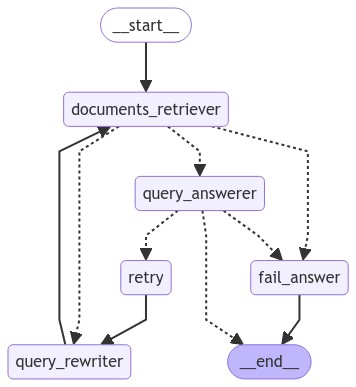

In [38]:
workflow = StateGraph(GraphState)

# Nodes
workflow.add_node(documents_retriever.__name__, documents_retriever)
workflow.add_node(query_rewriter.__name__, query_rewriter)
workflow.add_node(query_answerer.__name__, query_answerer)
workflow.add_node(retry.__name__, retry)
workflow.add_node(fail_answer.__name__, fail_answer)

# Edges
workflow.add_edge(START, documents_retriever.__name__)
workflow.add_conditional_edges(documents_retriever.__name__, context_checker)
workflow.add_edge(query_rewriter.__name__, documents_retriever.__name__)
workflow.add_conditional_edges(query_answerer.__name__, answer_checker)
workflow.add_edge(retry.__name__, query_rewriter.__name__)
workflow.add_edge(fail_answer.__name__, END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## Run


In [39]:
async def run(query: str, verbose=True) -> GraphState:
    initial_state: GraphState = {
        "query": query,
        "can_requery": 1,
        "can_retry": 1,
    }

    return await graph.ainvoke(initial_state)

In [40]:
result = await run("Who was Miyamoto Musashi?")

result['response']

documents_retriever
context_checker
------------------------------
binary_score='yes'
------------------------------
query_answerer
------------------------------
answer='Miyamoto Musashi was a Japanese swordsman, strategist, artist, and writer who became renowned through stories of his unique double-bladed swordsmanship and undefeated record in his 62 duels.' citations=[1]
------------------------------
answer_checker
------------------------------
Pass Hallucination Check: yes
------------------------------
------------------------------
Pass Answer Check: yes
------------------------------


CitedAnswer(answer='Miyamoto Musashi was a Japanese swordsman, strategist, artist, and writer who became renowned through stories of his unique double-bladed swordsmanship and undefeated record in his 62 duels.', citations=[1])

In [41]:
result = await run("What is the answer to the Great Question of Life, the Universe, and Everything?")

documents_retriever
context_checker
------------------------------
binary_score='yes'
------------------------------
query_answerer
------------------------------
answer='42' citations=[1]
------------------------------
answer_checker
------------------------------
Pass Hallucination Check: yes
------------------------------
------------------------------
Pass Answer Check: yes
------------------------------


In [42]:
result['response']

CitedAnswer(answer='42', citations=[1])

In [43]:
result

{'query': 'What is the answer to the Great Question of Life, the Universe, and Everything?',
 'can_requery': 1,
 'can_retry': 1,
 'documents': [Document(metadata={'title': 'Meaning of life', 'summary': 'The meaning of life pertains to the inherent significance or philosophical meaning of living (or existence in general). There is not a definitive answer, and thinking or discourse on the topic is sought in the English language through the question, "What is the meaning of life?" (or the related "Why are we here?" or "What is the purpose of existence?"). There have been many proposed answers to these questions from many different cultural and ideological backgrounds. The search for life\'s meaning has produced much philosophical, scientific, theological, and metaphysical speculation throughout history. Different people and cultures believe different things for the answer to this question. Opinions vary on the usefulness of using time and resources in the pursuit of an answer. Excessive p

In [47]:
result = await run("What is the exact number of grains of sand on all the beaches in the world?")

result

documents_retriever
context_checker
------------------------------
binary_score='no'
------------------------------
query_rewriter
------------------------------
How many grains of sand are on all beaches globally?
------------------------------
documents_retriever
context_checker
query_answerer
------------------------------
answer="I don't have enough information in the provided sources to answer this question." citations=[]
------------------------------
answer_checker
------------------------------
Pass Hallucination Check: no
------------------------------
retry
query_rewriter
------------------------------
How many grains of sand are on all beaches worldwide?
------------------------------
documents_retriever
context_checker
query_answerer
------------------------------
answer="I don't have enough information in the provided sources to answer this question." citations=[]
------------------------------
answer_checker
------------------------------
Pass Hallucination Check: no
----

{'query': 'What is the exact number of grains of sand on all the beaches in the world?',
 'requery': 'How many grains of sand are on all beaches worldwide?',
 'can_requery': 0,
 'can_retry': 0,
 'documents': [Document(metadata={'title': 'Coastal erosion', 'summary': 'Coastal erosion is the loss or displacement of land, or the long-term removal of sediment and rocks along the coastline due to the action of waves, currents, tides, wind-driven water, waterborne ice, or other impacts of storms. The landward retreat of the shoreline can be measured and described over a temporal scale of tides, seasons, and other short-term cyclic processes. Coastal erosion may be caused by hydraulic action, abrasion, impact and corrosion by wind and water, and other forces, natural or unnatural.\nOn non-rocky coasts, coastal erosion results in rock formations in areas where the coastline contains rock layers or fracture zones with varying resistance to erosion. Softer areas become eroded much faster than ha